# Module 2: Differential Privacy Algorithms

Copyright 2019 — for internal Census Bureau use

In [0]:
import numpy as np
import pandas as pd
import matplotlib as plt           
%matplotlib inline

## Quick Pandas Reference

**Load UCI Adult Dataset as a Pandas DataFrame**

In [0]:
import pandas as pd
names = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]
adult_df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",header=None, names=names, sep=",\s+", na_values="?", verbose=True, engine='python')
public_df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",header=None, names=names, sep=",\s+", na_values="?", verbose=True, skiprows=[0], engine='python')

**Explore the dataframe**



In [0]:
print("Columns Information:")
print(adult_df.info())
print("")
print("Summary statistics of Private dataset:")
print(adult_df.describe())
print("")
print("Summary statistics of Public dataset:")
print(public_df.describe())


**Access a specific value**

In [0]:
adult_df.at[0,'age']

**Select a subset of rows**

In [0]:
adult_df[0:4]

**Select a subset of rows and columns**

If you want all rows, just use 
```python
adult_df[['age', 'workclass']]
```

If you just want the age column:
```python
adult_df.age
```

In [0]:
adult_df[1:4][['age', 'workclass']]


**Query Selection**
Get all rows where the workclass is missing.
The method .head(5) only then gets the frist 5 rows

In [0]:
adult_df[pd.isna(adult_df.workclass)].head(5)


**Query Selection** get records with age 18, then count the number of non-missing values for each column

In [0]:
adult_df[adult_df.age == 18].count()

**Group By Queries**

In [0]:
adult_df.groupby(['marital-status']).mean()

**Get numpy array**

In [0]:
adult_df.age.values


## Differential Privacy Tools

**The Laplace Mechanism**
The input is mu - a number or a numpy array, along with the privacy budget epsilon and sensitivity of the query that produced mu.
Example, 
```python
laplace_mech(33.5, epsilon=1.0, sensitivity=2.0)
```
returns 33.5 + noise where noise is a sample from a Laplace distribution with scale 2.0/1.0.

Example where mu is an array
```python
laplace_mech(np.array([1.0, 2.1, 3.4]), epsilon=0.5, sensitivity=3.0)
```
returns `[1.0 + noise1, 2.1 + noise2, 3.4 + noise3]` where each noise variable is an independent sample from a Laplace distribution with scale $\frac{3.0}{0.5} = 6$.

In [0]:
import numpy as np
def laplace_mech(mu, epsilon, sensitivity=1.0):
    """ laplace mechanism, only for research purposes, not production"""
    eps = epsilon/float(sensitivity)
    scale = 1/eps
    np_shape = np.shape(mu)
    shape = None if np_shape == () else np_shape
    z = np.random.laplace(0.0, scale=scale, size=shape)
    return mu + z


**Error Evaluation**
How can we estimate the error of a differentially private algorithm? We use a **public** dataset, run the algorithm multiple times on it and compute the mean squared error (for example). The following function mse allows us to do that. Suppose we have a function called my_mechanism that we would like to call like
```python
my_mechanism(true_answer, epsilon, sensitivity, p1, p2 , p3) # p1, p2, p3 are some other parameters
```
and we would like to estimate its accuracy. We take a **public** dataset, compute true_answer from it and then call mse by telling it the true answer, the function we want to test and the parameters the function takes:
```
mse(true_answer, my_mechanism, true_answer, epsilon, sensitivity, p1, p2, p3)
```



In [0]:
def mse(true_answer, function_name, *params):
  """true_answer is either a scalar or numpy array"""
  niterations = 1000
  return sum(np.sum((true_answer - function_name(*params))**2) for x in range(niterations)) / float(niterations)

For example, calling
```python
mse(true_answer, laplace_mech, true_answer, 1.0, 1.0)
```
estimates the mean squared error of the Laplace Mechanism with epsilon=1.0 and senstiivity=1.0. It will return a number around 2.

In [0]:
true_answer = 5
mse(true_answer, laplace_mech, true_answer, 1.0, 1.0)

2.214910694156271

# Activities Using Basic DP Algorithms

## Background

We have a dataset of ficitious persons where each row records the sex, height, and weight of an individual.  Your task is to compute differentially private query answers for various questions related to body-mass index (BMI), which is defined as:

$\text{BMI} = \frac{\text{weight}}{\text{height}^2}$

Load and visualize the (synthetic) data.  Because this data is synthetic, it is a good playground for trying out various differentially private algorithms.

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/michaelghay/bootcamp/master/bmi.csv')
df = df[['gender', 'height', 'weight']]
df.head()

,gender,height,weight
0,F,1.603846,87.752176
1,M,1.839779,87.512242
2,M,1.804907,100.876156
3,F,1.566248,69.207358
4,F,1.607145,86.967960


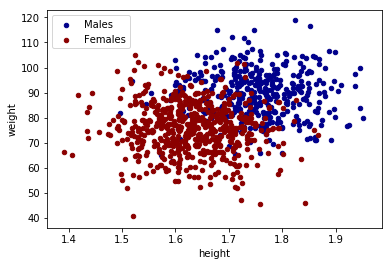

In [0]:
ax = df[df.gender=='M'].plot.scatter('height', 'weight', color='DarkBlue', label='Males')
df[df.gender=='F'].plot.scatter('height', 'weight', color='DarkRed', label='Females', ax=ax)

## Problem 1: Design a strategy to answer a set of queries

For this problem, you are tasked with answering the following four queries:

1. Number of Males
1. Number of Females
1. Number of Males with BMI < 25
1. Number of Females with BMI < 25

Design an $\epsilon$-differentially private algorithm that can answer all these questions. You may use the Laplace mechanism and the composition properties of differential privacy.   Write your implementation in `dp_strategy` below.

When you have completed your implementation, answer these questions:

*   What is your strategy?
*   Why is it is $\epsilon$-DP?  Give a convincing argument.
*   What is the total error?




In [0]:
# Problem 1: design strategy to answer these queries
# Number of Males
# Number of Females
# Number of Males with BMI < 25
# Number of Females with BMI < 25

# code that computes the true query answers on the synthetic data
# (you might find it helpful to see what pandas commands are being used)
def answer_queries(df):
  count_males = df[df.gender == 'M'].shape[0]
  count_females = df[df.gender == 'F'].shape[0]
  count_males_low_bmi = df[(df.gender == 'M') & (df.weight / df.height**2 < 25)].shape[0]
  count_females_low_bmi = df[(df.gender == 'F') & (df.weight / df.height**2 < 25)].shape[0]
  return np.array([
                  count_males, 
                  count_females,
                  count_males_low_bmi,
                  count_females_low_bmi])

true_answers = answer_queries(df)


def dp_strategy(df, eps):
  # compute all four quantities given a total privacy loss budget of eps
  # replace the 0s below with your noisy answers
  noisy_count_males = 0       # todo: replace with your noisy answer
  noisy_count_females = 0     # todo: replace with your noisy answer
  noisy_count_males_low_bmi = 0    # todo: replace with your noisy answer
  noisy_count_females_low_bmi = 0  # todo: replace with your noisy answer


  # leave this as is
  return np.array([
          noisy_count_males, 
          noisy_count_females,
          noisy_count_males_low_bmi,
          noisy_count_females_low_bmi
         ])

# Compute mse of dp_strategy
eps = 0.1
answer = mse(true_answers, dp_strategy, df, eps)
print("mse is ", answer)

mse is  540882.0


## Problem 2: Average BMI

For this problem, there are two tasks:


1.   What is the sensitivity of the query that computes the average BMI?
2.   Write an $\epsilon$-differentially private algorithm for computing the average BMI.



In [0]:
# Problem 2: compute average BMI


# code that computes the true answer on the synthetic data
# (you might find it helpful to see what pandas commands are being used)
avg_bmi = (df.weight / df.height**2).mean()

# your DP implementation
def dp_avg_bmi(df, eps):

  noisy_avg_bmi = 0       # todo: replace with your DP noisy answer

  return noisy_avg_bmi

# Compute mse of dp_strategy
eps = 0.1
answer = mse(avg_bmi, dp_avg_bmi, df, eps)
print("mse is ", answer)

mse is  834.6825708294145
